<a href="https://colab.research.google.com/github/genzj/llm-fine-tune-course/blob/main/Lab_02_Fine_tuning_using_QLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 首先修改会话类型为GPU

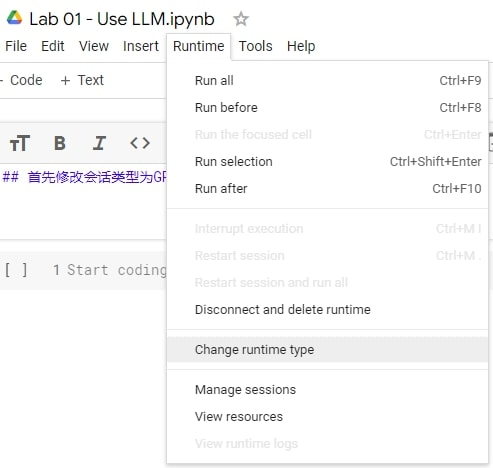

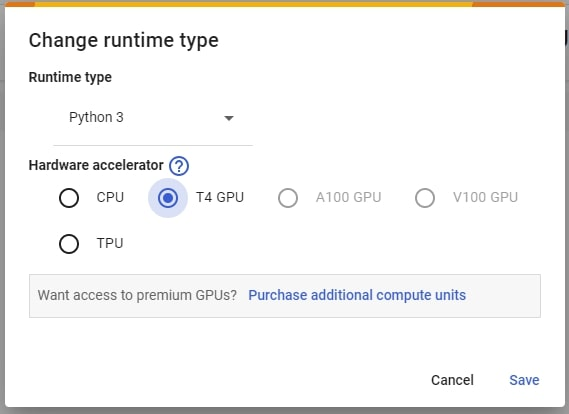

In [1]:
# 安装依赖库
!pip install transformers==4.31.0 datasets==2.13.0 peft==0.4.0 \
  accelerate==0.21.0 bitsandbytes==0.40.2 trl==0.4.7 mlflow \
  sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

## 数据加载

In [2]:
from datasets import load_dataset
from IPython.display import display, display_markdown
import pandas as pd
import textwrap

In [3]:
rd_ds = load_dataset("xiyuez/red-dot-design-award-product-description")
rd_df = pd.DataFrame(rd_ds['train'])
rd_df['instruction'] = 'Create a detailed description for the following product: '+ rd_df['product']+', belonging to category: '+ rd_df['category']
rd_df = rd_df[['instruction', 'description']]
display(rd_df.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/xiyuez___parquet/xiyuez--red-dot-design-award-product-description-45eb1fdce1c29838/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

(21183, 2)

In [4]:
rd_df_sample = rd_df.sample(n=500, random_state=42)

template = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{}

### Response:\n"""

rd_df_sample['prompt'] = rd_df_sample["instruction"].apply(template.format)
rd_df_sample['response'] = rd_df_sample['description'] +  "\n### End"
rd_df_sample = rd_df_sample[['prompt', 'response']]
display(rd_df_sample)

,prompt,response
18952,Below is an instruction that describes a task....,The CG8565 is a gaming PC offering space for h...
12584,Below is an instruction that describes a task....,The iSHOXS BullBar ProX mount can be used to a...
5702,Below is an instruction that describes a task....,The S81 Pro focuses on two things: outstanding...
20503,Below is an instruction that describes a task....,The CenFlex superfinish machine is designed fo...
2480,Below is an instruction that describes a task....,The THALION S gas absorption heat pump uses na...
...,...,...
2026,Below is an instruction that describes a task....,The Gas&Smoke Two-in-One Detector integrates a...
5960,Below is an instruction that describes a task....,This umbrella comes with a matte aluminium sha...
18734,Below is an instruction that describes a task....,Suitable for both left-handers and right-hande...
13811,Below is an instruction that describes a task....,This electric downhill mountain bike features ...


In [5]:
def print_long_string(s: str, width=70):
  print('\n'.join(textwrap.wrap(s, width=width)))

In [6]:
print(rd_df_sample.iloc[0, 0])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: CG8565, belonging to category: Desktop Computer

### Response:



In [7]:
print('Prompt:')
print(rd_df_sample.iloc[0, 0])
print('-' * 140)
print('Response:')
print(rd_df_sample.iloc[0, 1])

Prompt:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: CG8565, belonging to category: Desktop Computer

### Response:

--------------------------------------------------------------------------------------------------------------------------------------------
Response:
The CG8565 is a gaming PC offering space for high-quality equipment. The Windows 7 system works with an Intel Core i7 2600K processor and supports up to 32 GB of working memory. Two graphics cards, an SSD hard drive, an efficient water-cooling system and three chassis fans guarantee excellent performance. At the push of a button, the system can be overclocked by up to  35 per cent during continuous operation.
### End


## 加载模型

In [8]:
from peft import PeftModel, get_peft_model, LoraConfig
from transformers import LlamaTokenizer, LlamaForCausalLM
import torch
from transformers import BitsAndBytesConfig
from trl import SFTTrainer
import mlflow

In [9]:
df = rd_df_sample.copy()
df['text'] = df["prompt"]+df["response"]
df.drop(columns=['prompt', 'response'], inplace=True)
display(df)
print(df.shape)
print(df.iloc[0, 0])

,text
18952,Below is an instruction that describes a task....
12584,Below is an instruction that describes a task....
5702,Below is an instruction that describes a task....
20503,Below is an instruction that describes a task....
2480,Below is an instruction that describes a task....
...,...
2026,Below is an instruction that describes a task....
5960,Below is an instruction that describes a task....
18734,Below is an instruction that describes a task....
13811,Below is an instruction that describes a task....


(500, 1)
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a detailed description for the following product: CG8565, belonging to category: Desktop Computer

### Response:
The CG8565 is a gaming PC offering space for high-quality equipment. The Windows 7 system works with an Intel Core i7 2600K processor and supports up to 32 GB of working memory. Two graphics cards, an SSD hard drive, an efficient water-cooling system and three chassis fans guarantee excellent performance. At the push of a button, the system can be overclocked by up to  35 per cent during continuous operation.
### End


In [10]:
from datasets import Dataset
dataset = Dataset.from_pandas(df).train_test_split(test_size=0.05, seed=42)

In [11]:
target_modules = ['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj','lm_head']
#or if only tageting attention blocks
# target_modules = ['q_proj','v_proj']

lora_config = LoraConfig(
    r=8,#or r=16
    lora_alpha=8,
    lora_dropout=0.05,
    bias="none",
    target_modules = target_modules,
    task_type="CAUSAL_LM",
)

In [12]:
from transformers import TrainingArguments

base_dir = 'ft_using_qlora'
per_device_train_batch_size = 4
gradient_accumulation_steps = 4
optim = 'adamw_hf'
learning_rate = 1e-5
max_grad_norm = 0.3
warmup_ratio = 0.03
lr_scheduler_type = "linear"
epochs = 5.0

training_args = TrainingArguments(
    output_dir=base_dir,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs = epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [13]:
model_path = 'openlm-research/open_llama_3b_v2'

tokenizer = LlamaTokenizer.from_pretrained(model_path)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

nf4_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)

model = LlamaForCausalLM.from_pretrained(
    model_path, device_map='auto', quantization_config=nf4_config,
)

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [14]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 12,994,560 || all params: 1,828,716,160 || trainable%: 0.7105837572956101


In [15]:
trainer = SFTTrainer(
    model,
    train_dataset=dataset['train'],
    eval_dataset = dataset['test'],
    dataset_text_field="text",
    max_seq_length=256,
    args=training_args,
)
#Upcast layer norms to float 32 for stability
for name, module in trainer.model.named_modules():
  if "norm" in name:
    module = module.to(torch.float32)

Using pad_token, but it is not set yet.


Map:   0%|          | 0/475 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

In [16]:
# Initiate the training process
with mlflow.start_run(run_name='run_name_of_choice'):
    trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,No log,2.887067
1,No log,2.744315
2,No log,2.608612
4,No log,2.513691
4,No log,2.484316


In [20]:
trainer.save_model(f'{base_dir}/fine-tuned-model')

In [21]:
# workaround of https://github.com/googlecolab/colabtools/issues/3409
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!tar cvzf "fine-tuned-model.tgz" "$base_dir/fine-tuned-model"

ft_using_qlora/fine-tuned-model/
ft_using_qlora/fine-tuned-model/tokenizer.json
ft_using_qlora/fine-tuned-model/adapter_model.bin
ft_using_qlora/fine-tuned-model/README.md
ft_using_qlora/fine-tuned-model/special_tokens_map.json
ft_using_qlora/fine-tuned-model/tokenizer.model
ft_using_qlora/fine-tuned-model/training_args.bin
ft_using_qlora/fine-tuned-model/tokenizer_config.json
ft_using_qlora/fine-tuned-model/adapter_config.json


## 测试模型

选择菜单`Runtime` -> `Restart Session` 并从下一个cell开始执行

In [1]:
from transformers import LlamaTokenizer, LlamaForCausalLM
from peft import PeftModel

In [2]:
model_path = 'openlm-research/open_llama_3b_v2'

tokenizer = LlamaTokenizer.from_pretrained(model_path)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = LlamaForCausalLM.from_pretrained(
    model_path, load_in_8bit=True, device_map='auto',
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [3]:
base_dir = 'ft_using_qlora'

In [4]:
peft_model_id = f'./{base_dir}/fine-tuned-model'

peft_model = PeftModel.from_pretrained(model, peft_model_id)

In [5]:
test_strings = ["Create a detailed description for the following product: CG8565, belonging to category: Desktop Computer",
"Create a detailed description for the following product: iSHOXS BullBar ProX, belonging to category: Action Cam Mount",
"Create a detailed description for the following product: S81 Pro, belonging to category: 4K OLED TV"]

In [6]:
predictions = []
for test in test_strings:
  prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

  ### Instruction:
  {}

  ### Response:""".format(test)
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')

  generation_output = peft_model.generate(
      input_ids=input_ids, max_new_tokens=156
  )
  predictions.append(tokenizer.decode(generation_output[0]))

In [7]:
for p in predictions:
  print()
  print(p)
  print('-' * 100)


<s>Below is an instruction that describes a task. Write a response that appropriately completes the request.

  ### Instruction:
  Create a detailed description for the following product: CG8565, belonging to category: Desktop Computer

  ### Response:
  The CG8565 is a desktop computer that has a 15.6-inch screen, a 1TB hard drive, and a 128GB SSD. It has a 1.8GHz Intel Core i5 processor, 8GB of RAM, and a 1920x1080 resolution.

  ### End

### Example Response

```
### Response:
The CG8565 is a desktop computer that has a 15.6-inch screen, a 1TB hard drive, and a 128GB SSD. It has a 1.8GHz Intel Core i5 processor, 8GB of RAM,
----------------------------------------------------------------------------------------------------

<s>Below is an instruction that describes a task. Write a response that appropriately completes the request.

  ### Instruction:
  Create a detailed description for the following product: iSHOXS BullBar ProX, belonging to category: Action Cam Mount

  ### Respon

In [10]:
free_style_prompt = 'I think I should by the S81 Pro OLED TV, because it'

input_ids = tokenizer(free_style_prompt, return_tensors="pt").input_ids.to('cuda')

generation_output = model.generate(
    input_ids=input_ids, max_new_tokens=156
)
prediction = tokenizer.decode(generation_output[0])

print(prediction)

<s>I think I should by the S81 Pro OLED TV, because it has a 120Hz refresh rate, and I think it would be a good choice for me.
I think I should by the S81 Pro OLED TV, because it has a 120Hz refresh rate, and I think it would be a good choice for me.
I think I should buy the S81 Pro OLED TV, because it has a 120Hz refresh rate, and I think it would be a good choice for me.
I think I should buy the S81 Pro OLED TV, because it has a 120Hz refresh rate, and I think it would be a good choice for me.
I think I should buy the S81 Pro OLED TV, because it
